In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import clear_output, display, update_display
import matplotlib.pyplot as plt

from agent_code.tensor_agent.hyperparameters import hp

clear_output()

# Game Check

In [2]:
from simple import Game

Agents [(15, 15, 'test', 1, 0)]
Arena (17, 17)
Coins (17, 17) # 9.0


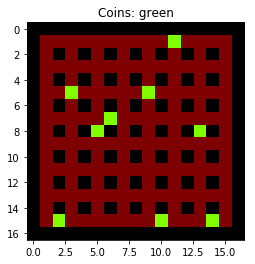

In [19]:
game = Game(*Game.create_arena(['test']))
print('Agents', game.agents)
print('Arena', game.arena.shape)
print('Coins', game.coins.shape, '#', np.sum(game.coins))

plt.title('Coins: green')
plt.imshow(np.stack([game.arena / 2 + 0.5, game.coins, game.bombs + game.explosions]).T)
plt.show()

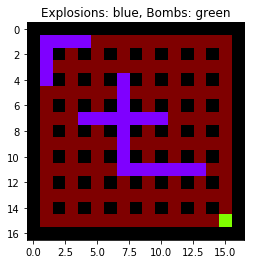

In [20]:
game.bombs[7, 7] = 1
game.bombs[10, 11] = 1
game.bombs[1, 1] = 1
game.step({'test': 'BOMB'})

plt.title('Explosions: blue, Bombs: green')
plt.imshow(np.stack([game.arena / 2 + 0.5, game.bombs / np.maximum(np.max(game.bombs), 1.), game.explosions / np.max(game.explosions)]).T)
plt.show()

In [21]:
# with triggered bomb from cell above
for i in range(5):
    print(game.agents[0])
    game.step({'test': 'BOMB'})

(15, 15, 'test', -4, 0)
(15, 15, 'test', -3, 0)
(15, 15, 'test', -2, 0)
(15, 15, 'test', -1, 0)
(15, 15, 'test', 0, 0)
agent (15, 15, 'test', 1, 0) was bombed at 15, 15 in step 6
suicide


In [33]:
game = Game(*Game.create_arena(['test']))
x, y = np.stack(np.where(game.coins == 1)).T[0]
_, _, name, bombs_left, score = game.agents[0]
game.agents[0] = (x, y, name, bombs_left, score)

reward = game.step({name: 'WAIT'})

assert(reward[name] == s.reward_coin)

# X

In [34]:
from agent_code.tensor_agent.X import RelativeX2, AbsoluteX2, Minimal
from simple import Game

In [35]:
game = Game(*Game.create_arena(['test']))
game_state = game.get_game_state(game.agents[0])

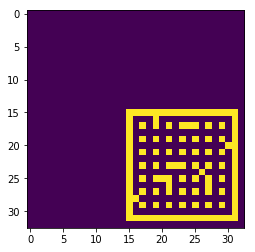

In [37]:
X = RelativeX2.get(game_state)
img = np.sum(X, axis=2)
plt.imshow(img / np.max(img))

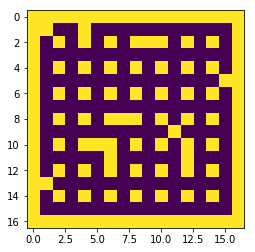

In [38]:
X = AbsoluteX2.get(game_state)
img = np.sum(X, axis=2)
plt.imshow(img / np.max(img))

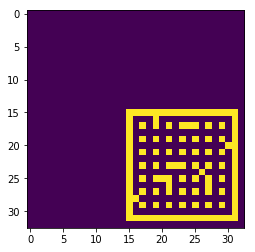

In [39]:
X = Minimal.get(game_state)
img = np.sum(X, axis=2)
plt.imshow(img / np.max(img))

# MultiStepBuffer Check

In [2]:
from agent_code.tensor_agent.agent import MultiStepBuffer

from agent_code.tensor_agent.model import FullModel

In [16]:
input_shape = (4,4,1)
D = 6
model = FullModel(input_shape, D)
clear_output()

ms_buffer = MultiStepBuffer()

X = np.zeros((4,4,1))
X[1,2] = 1
action = 2
reward = 1-0.0001
sample = [X, action, reward]
result = ms_buffer.push(*sample, target_model=model.target)
assert(result is None)
result = ms_buffer.push(*sample, target_model=model.target)
assert(result is None)
result = ms_buffer.push(*sample, target_model=model.target)
assert(result is None)
result = ms_buffer.push(*sample, target_model=model.target)
assert(np.all(result[0] == X) and result[1] == action)

Xs, actions, rewards = ms_buffer.clear()
assert(np.all(Xs[hp.multi_step_n-1] == X) and actions[hp.multi_step_n-1] == action and rewards[hp.multi_step_n-1] == reward)
assert(rewards[-1] == reward and rewards[-2] == reward * (1 + hp.discount_factor))

# Sum Tree

In [2]:
from agent_code.tensor_agent.per import SumTree

In [26]:
capacity = 6
tree = SumTree(capacity)

In [27]:
for i in range(capacity):
    tree.add(1., 'huhu')

In [28]:
tree.tree

array([6., 4., 2., 2., 2., 1., 1., 1., 1., 1., 1.])

In [29]:
tree.update(capacity-1, 0.5)
assert(np.sum(tree.tree[-tree.capacity:] != 1) == 1)

In [30]:
samples = np.array([tree.get_leave(v+0.5) for v in range(capacity)])[:,0].astype(int)
print('min:',np.min(samples),'max:',np.max(samples))
assert(np.min(samples) == capacity-1 and np.max(samples) == (capacity-1) * 2)

min: 5 max: 10


# Augmentation

In [81]:
from agent_code.tensor_agent.agent import augment
from simple import Game
from agent_code.tensor_agent.X import Minimal as game_state_X
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']

In [51]:
game = Game(*Game.create_arena(['test']))

In [57]:
X = game_state_X.get(game.get_game_state(game.agents[0]))
X.shape

(33, 33, 2)

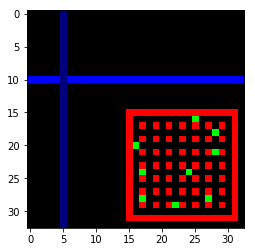

In [92]:
def plotX(X):
    img = np.zeros((X.shape[0], X.shape[1], 3))
    img[:,:,[0,1]] = X
    img[10,:,2] = 1 # x axis -> Left and right is changed if this axis is switched
    img[:,5,2] = 0.5 # y axis -> Up and down is changed if this axis is switched
    plt.imshow(img)

plotX(X)

In [120]:
augmented = augment(X, 0)
Xs = [a[0] for a in augmented]
actions = [a[1] for a in augmented]

RIGHT


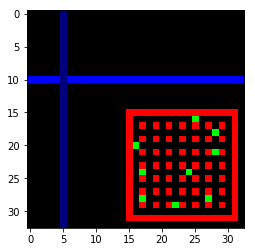

In [121]:
plotX(Xs[0])
print(choices[actions[0]])

LEFT


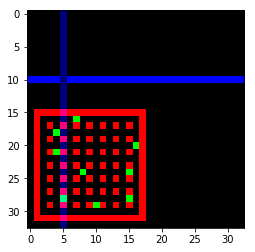

In [122]:
plotX(Xs[1])
print(choices[actions[1]])

RIGHT


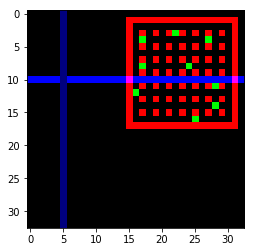

In [123]:
plotX(Xs[2])
print(choices[actions[2]])

LEFT


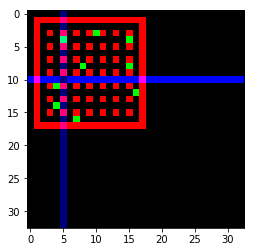

In [124]:
plotX(Xs[3])
print(choices[actions[3]])

# Agent

In [4]:
from agent_code.tensor_agent.agent import TensorAgent

In [5]:
hp.buffer_size = 32
hp.sample_size = 32
hp.learning_rate = 0.1
hp.update_frequency = 1
hp.target_network_period = 1

In [6]:
D = 6
agent = TensorAgent((2,2,1), 6)
clear_output()

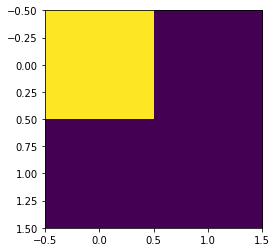

In [7]:
X = np.zeros((2,2,1))
X[0,0,0] = 1
action1 = 0
action2 = 1
reward1 = 1
reward2 = -1
plt.imshow(X[:,:,0])

In [ ]:
for i in range(1000):
    agent.reward_update([X, action1, reward1])
    agent.end_of_episode()
    agent.reward_update([X, action2, reward2])
    agent.end_of_episode()
clear_output()

In [9]:
agent.model.target.predict(np.array([X]))

array([[ 1.0003811 , -1.0004103 ,  0.38252765, -0.39823732,  0.07964045,
         0.10601245]], dtype=float32)